# Developing a GAN for wildfire image generation

In [1]:
!pip install livelossplot

In [2]:
#necessary imports
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import random

from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.nn.utils.spectral_norm as spectral_norm
from torch.utils.data import Dataset

import scipy.ndimage as ndi
from scipy.spatial.distance import pdist, squareform

from livelossplot import PlotLosses


In [3]:
#mounting to drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import sys
# Add the tools directory to the system path
tools_path = 'gdrive/MyDrive/Colab Notebooks/'
if tools_path not in sys.path:
    sys.path.append(tools_path)

# Now you can import everything from the tools package
from tools import *

Please note: this reshaping is only used in the first model. The data is handled differently after that.

In [5]:
# load the training data and reshape
train = np.load('gdrive/MyDrive/Colab Notebooks/Ferguson_fire_train.npy')

print(f"Before reshaping: {np.shape(train)}")

train_1D = np.reshape(
    train, (np.shape(train)[0], np.shape(train)[1] * np.shape(train)[2])
)
print(f"After reshaping: {train_1D.shape}")

train = np.array(train)
train_1D = np.array(train_1D)

Before reshaping: (12500, 256, 256)
After reshaping: (12500, 65536)


In [6]:
# load the test data and reshape
test = np.load('gdrive/MyDrive/Colab Notebooks/Ferguson_fire_test.npy')

print(f"Before reshaping: {np.shape(test)}")

test_1D = np.reshape(
    test, (np.shape(test)[0], np.shape(test)[1] * np.shape(test)[2])
)
print(f"After reshaping: {test_1D.shape}")

test = np.array(test)
test_1D = np.array(test_1D)

Before reshaping: (5000, 256, 256)
After reshaping: (5000, 65536)


In [7]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## First Model Attempt - Basic GAN architecture

In [ ]:
G, D, G_optimizer, D_optimizer = build_model(Generator_basic_GAN, Discriminator_basic_GAN)

D_train and G_train are different, because of how we load in the data, for this model as opposed to the others. This model will use functions called 'D_train_basic' and 'G_train_basic'.

Classic DataLoader, no transformations applied in this first attempt. This is not packaged because it is a different Dataloader and model running than the rest of the attempts.

The sustainability is a little lower for this first model because it was distinct from the others, but we will improve the sustainability in the rest of the notebook, starting with the DCGAN architecture.

In [8]:
# DataLoader

# Convert your training data to PyTorch tensors
train_data = torch.tensor(train_1D, dtype=torch.float32)
test_data = torch.tensor(test_1D, dtype=torch.float32)

train_dataset = TensorDataset(train_data)
test_dataset = TensorDataset(test_data)

# Specify batch size
batch_size = 100

# Create a DataLoader for your training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

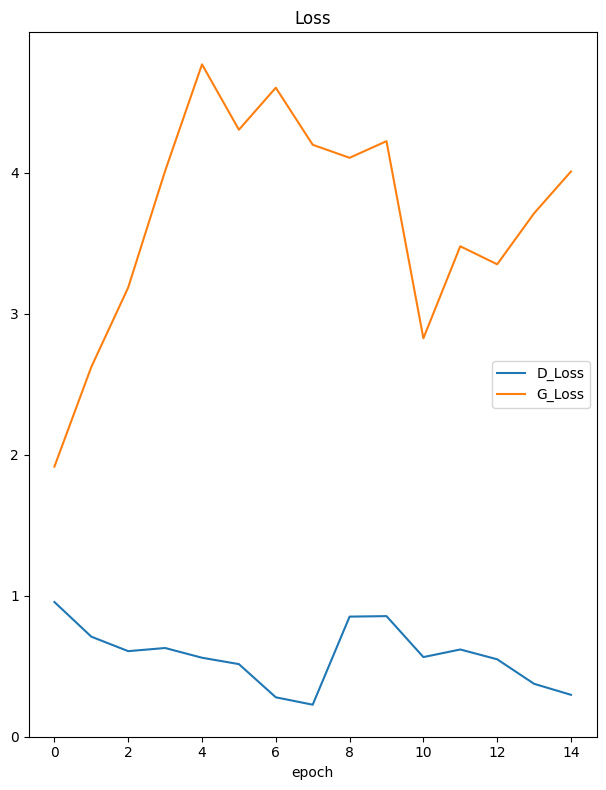

Loss
	D_Loss           	 (min:    0.226, max:    0.955, cur:    0.296)
	G_Loss           	 (min:    1.915, max:    4.769, cur:    4.009)


In [ ]:
#I will later make a helper function to run this model, but this one
#is loaded a little differently, so I will just run this one using a
#hard-coded cell

n_epoch = 15
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D_losses, G_losses = [], []
    logs = {}

    for batch_idx, (real_images,) in enumerate(train_loader):
        real_images = real_images.view(-1, 256*256).to(device)

        D_loss = D_train_basic(G, D, D_optimizer, real_images, device)
        G_loss = G_train_basic(G, D, G_optimizer)

        D_losses.append(D_loss)
        G_losses.append(G_loss)

    logs['D_Loss'] = torch.tensor(D_losses).mean().item()
    logs['G_Loss'] = torch.tensor(G_losses).mean().item()

    liveloss.update(logs)
    liveloss.draw()

    # save after training
    if(np.mod(epoch, 100) == 0):
      # torch.save(G.state_dict(), "./GAN/First_attempt{:03d}.pth".format(epoch))
      torch.save(G.state_dict(), "gdrive/MyDrive/Colab Notebooks/First_attempt{:03d}.pth".format(epoch))


This livelossplot is not super inspiring, so we are going to try a DCGAN before we attempt to calculate the MSE or visualize the output

# Trying a DCGAN

Re-establishing the Generator and Discriminator Architecture

This DCGAN architecture consists of a generator and a discriminator. The generator starts with a noise vector, which is projected and reshaped through a fully connected layer into a higher-dimensional space. This tensor then passes through several convolutional blocks with batch normalization, LeakyReLU activation, and upsampling layers, progressively refining and increasing the image resolution. The final output layer uses a Tanh activation function to generate 256x256 grayscale images with pixel values scaled between -1 and 1.

The discriminator acts as a binary classifier to distinguish real images from generated ones. It processes the input image through a series of convolutional layers, each followed by LeakyReLU activation, dropout for regularization, and batch normalization to stabilize training. These layers downsample the image while increasing feature map depth. The final convolutional output is flattened and fed into a fully connected layer with a Sigmoid activation, producing a probability that indicates whether the image is real or fake.

In [8]:
G, D, G_optimizer, D_optimizer = build_model(Generator_DCGAN_first_attempt, Discriminator_DCGAN_first_attempt)

## Custom Data Processor

Since we are working with numpy data, we are creating a custom class so that we can apply transformations

Establishing a helper function for the data loader

In [10]:
train_path = 'gdrive/MyDrive/Colab Notebooks/Ferguson_fire_train.npy'
test_path = 'gdrive/MyDrive/Colab Notebooks/Ferguson_fire_test.npy'

In [10]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5), std=(0.5))])

train_loader, test_loader = data_loader(transform, train_path, test_path)


Resetting D_train and G_train to work with the new architecture; this will be used in the rest of the notebook

Establishing a plotting helper function

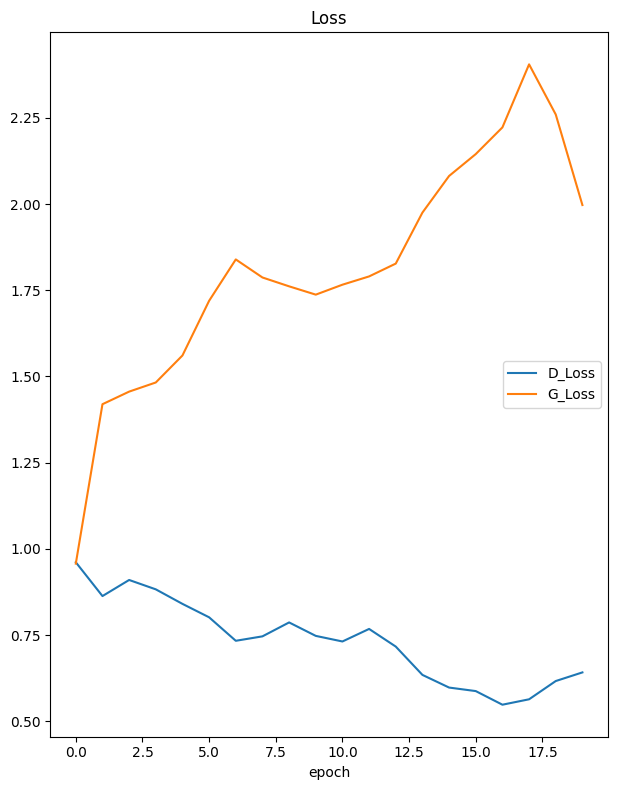

Loss
	D_Loss           	 (min:    0.548, max:    0.961, cur:    0.642)
	G_Loss           	 (min:    0.957, max:    2.405, cur:    1.997)


In [11]:
model_runner(D, G, D_optimizer, G_optimizer, 20, 10, train_loader, "DCGAN_1_", device)

Establishing a helper function to test the MSE loss

In [12]:
#Calculating the MSE for this case
mse = calculate_mse(test_loader, G, device)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.22698407649993896


Establishing helper functions to visualize the images, either generated or from the original training set.

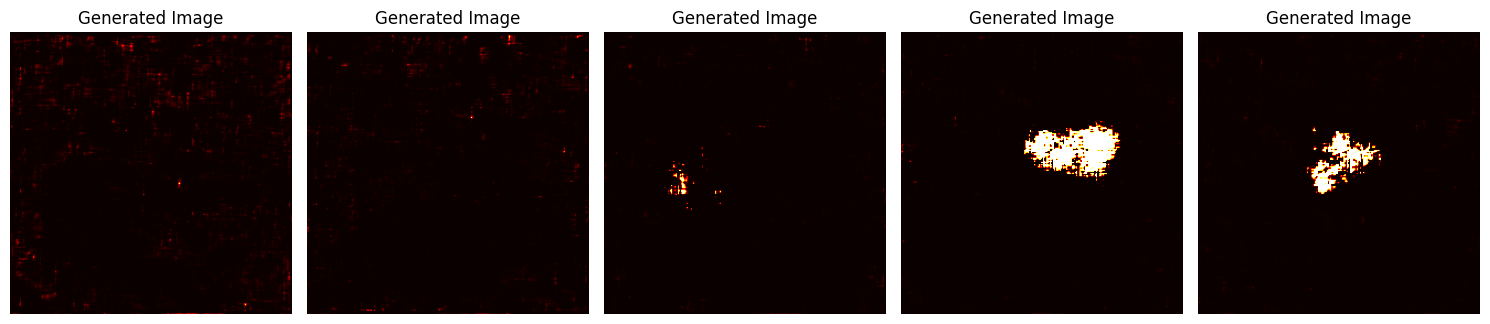

tensor([[[[-0.9996, -0.9999, -0.9998,  ..., -0.9999, -1.0000, -0.9999],
          [-0.9999, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9999],
          [-0.9988, -0.9997, -0.9998,  ..., -0.9996, -0.9998, -0.9993],
          ...,
          [-0.9991, -0.9998, -0.9999,  ..., -0.9993, -0.9999, -0.9998],
          [-0.9985, -0.9996, -0.9995,  ..., -0.9999, -1.0000, -1.0000],
          [-0.9918, -0.9912, -0.9710,  ..., -0.9981, -0.9999, -0.9995]]],


        [[[-0.9996, -1.0000, -0.9999,  ..., -0.9999, -1.0000, -1.0000],
          [-0.9998, -1.0000, -0.9999,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9984, -0.9996, -0.9998,  ..., -0.9999, -1.0000, -1.0000],
          ...,
          [-0.9995, -0.9997, -0.9997,  ..., -0.9989, -0.9999, -0.9998],
          [-0.9996, -0.9999, -0.9998,  ..., -0.9999, -1.0000, -1.0000],
          [-0.9964, -0.9976, -0.9928,  ..., -0.9992, -1.0000, -0.9998]]],


        [[[-0.9997, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9999, -1.000

In [13]:
# Visualize generated images
visualize_generated_images(G, device, num_images_to_generate=5)

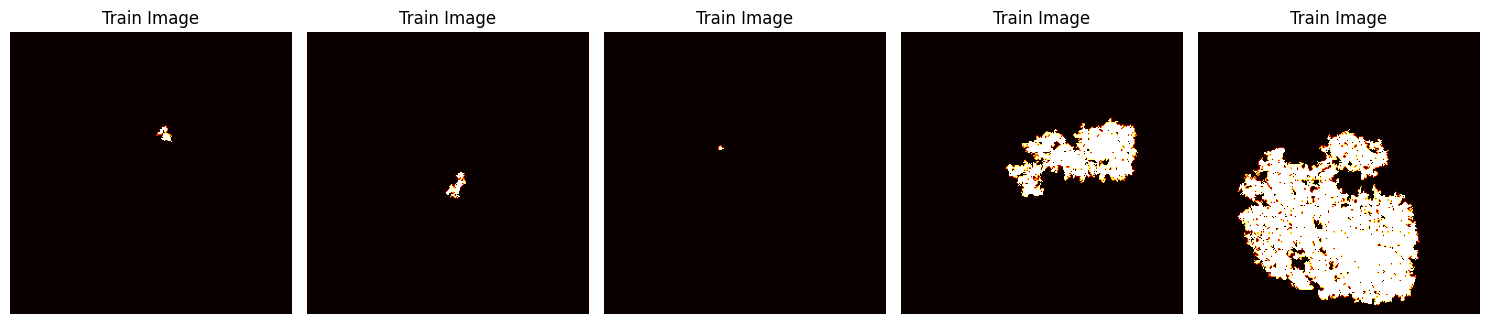

In [14]:
visualize_random_train_images(train_loader, num_images_to_show=5)

These images are a little bit blurry, and also are missing the distinctive plumes you see in the training images. I am going to try another structure.

## Center Zoom and Upsampling with Spectral Normalization

First, I want to think about doing some image augmentation with central zoom. Since most of the fires exist in the middle of the image, cutting out some of the black space in the background may be able to get us better, finer-grained representations.

Additionally, I am going to change the architecture, principally in order to integrate upsampling with spectral normalization. I will explain that further in the next markdown cell.

In [19]:
# import torchvision.transforms.functional as F

# Define the central zoom factor
zoom_factor = 2  # Adjust this value as needed

# Update the transformation pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),
    CenterZoom(zoom_factor),  # Apply central zoom
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])


In [20]:
train_loader, test_loader = data_loader(transform, train_path, test_path)

In this DCGAN, the generator transforms a noise vector into a high-resolution image using fully connected and transposed convolutional layers. It upsamples the noise tensor gradually to refine features and produce grayscale images with values between -1 and 1. The discriminator, meanwhile, is a binary classifier that distinguishes real from generated images. It uses spectral normalization and batch normalization in convolutional layers to stabilize training. The discriminator downsamples images to extract features and outputs a probability indicating the image's authenticity.

In [21]:
#building the model
G, D, G_optimizer, D_optimizer = build_model(Generator_final_model, Discriminator_final_model)

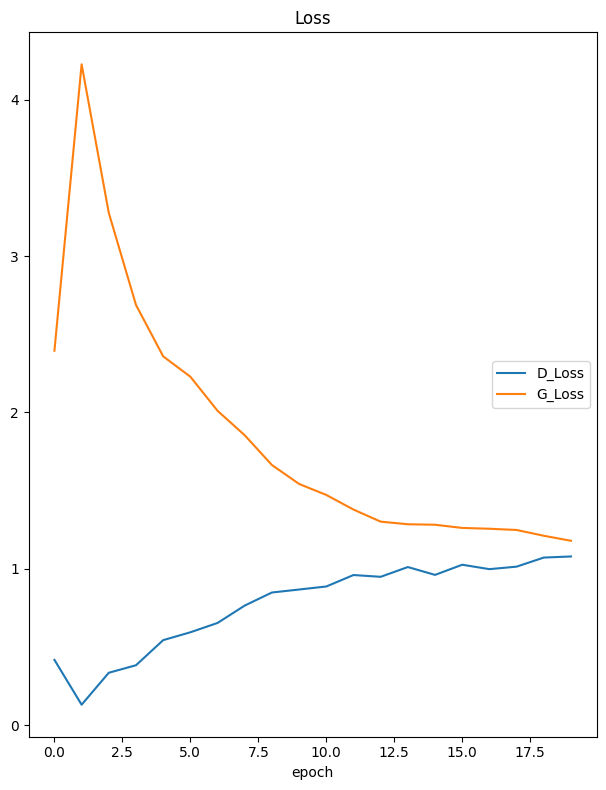

Loss
	D_Loss           	 (min:    0.130, max:    1.079, cur:    1.079)
	G_Loss           	 (min:    1.179, max:    4.227, cur:    1.179)


In [22]:
#running the model

model_runner(D, G, D_optimizer, G_optimizer, 20, 10, train_loader, "DCGAN_upsample_centerzoom_", device)

In [23]:
mse = calculate_mse(test_loader, G, device)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.6580431675910949


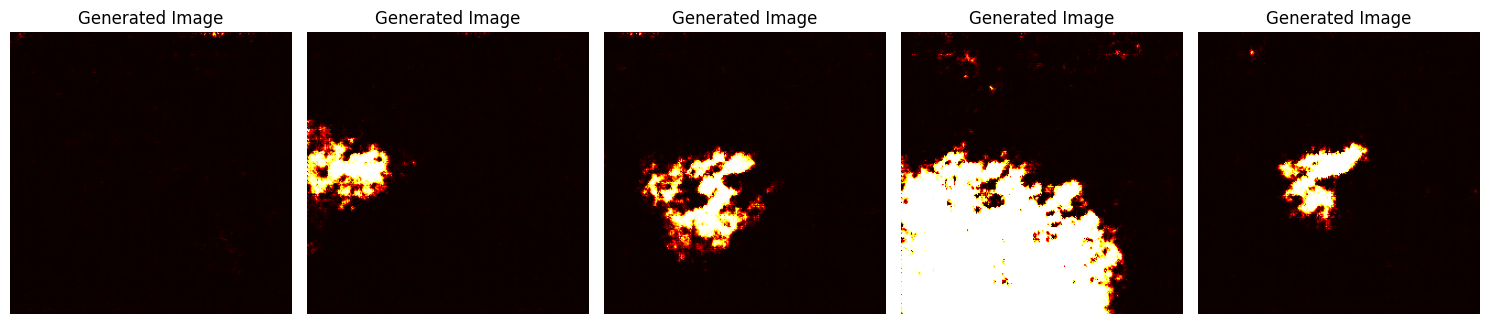

tensor([[[[-0.9252, -0.9829, -0.9791,  ..., -0.9791, -0.9885, -0.9069],
          [-0.9782, -0.9868, -0.9988,  ..., -0.9610, -0.9976, -0.9909],
          [-0.9868, -0.9965, -0.9987,  ..., -0.9919, -0.9996, -0.9878],
          ...,
          [-0.9890, -0.9981, -0.9991,  ..., -0.9962, -0.9992, -0.9942],
          [-0.9881, -0.9978, -0.9983,  ..., -0.9919, -0.9998, -0.9865],
          [-0.9797, -0.9968, -0.9910,  ..., -0.9960, -0.9923, -0.8894]]],


        [[[-0.9121, -0.9821, -0.9820,  ..., -0.9665, -0.9877, -0.9187],
          [-0.9721, -0.9874, -0.9976,  ..., -0.9827, -0.9990, -0.9931],
          [-0.9829, -0.9952, -0.9989,  ..., -0.9939, -0.9997, -0.9927],
          ...,
          [-0.9823, -0.9990, -0.9996,  ..., -0.9971, -0.9995, -0.9954],
          [-0.9869, -0.9974, -0.9995,  ..., -0.9950, -0.9999, -0.9900],
          [-0.9743, -0.9963, -0.9953,  ..., -0.9972, -0.9943, -0.8844]]],


        [[[-0.9176, -0.9831, -0.9822,  ..., -0.9771, -0.9895, -0.9166],
          [-0.9753, -0.991

In [24]:
visualize_generated_images(G, device, num_images_to_generate=5)


I think the central zoom has made this unintelligble.

## Upsampling without Central Zoom

Same architecture without central zoom

In [25]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

In [26]:
train_loader, test_loader = data_loader(transform, train_path, test_path)

In [27]:
#building the model
G, D, G_optimizer, D_optimizer = build_model(Generator_final_model, Discriminator_final_model)

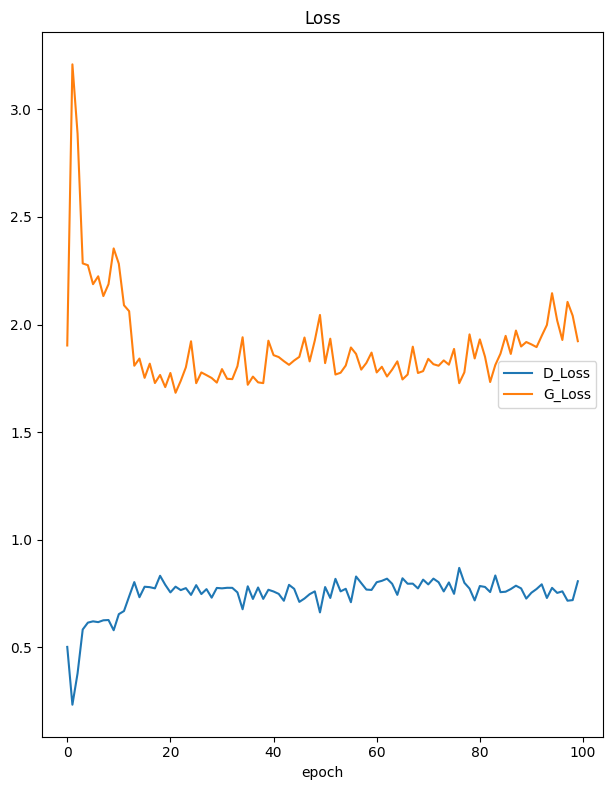

Loss
	D_Loss           	 (min:    0.232, max:    0.868, cur:    0.806)
	G_Loss           	 (min:    1.683, max:    3.210, cur:    1.922)


In [29]:
#running the model

model_runner(D, G, D_optimizer, G_optimizer, 100, 10, train_loader, "DCGAN_upsample_100_", device)

In [30]:
mse = calculate_mse(test_loader, G, device)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.22298245936632155


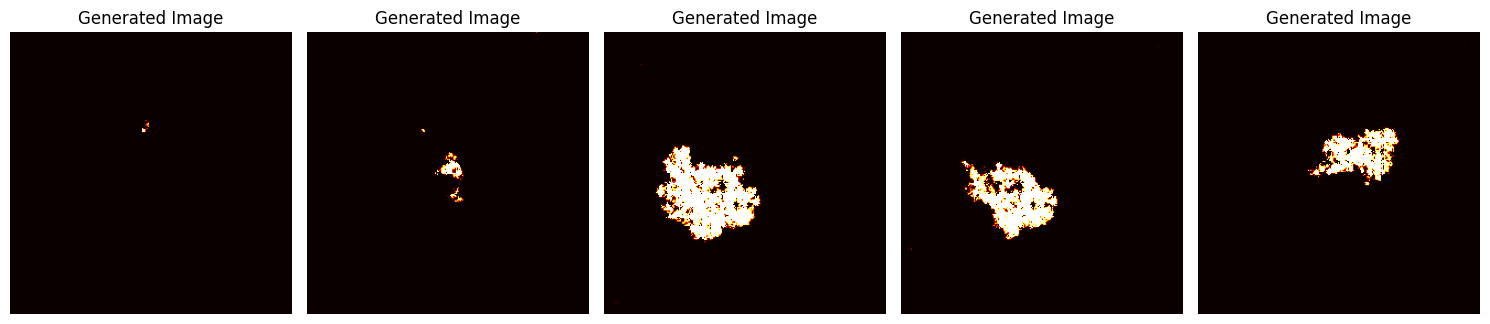

tensor([[[[-0.9865, -0.9990, -0.9993,  ..., -0.9999, -1.0000, -0.9935],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9999],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9999],
          [-0.9991, -1.0000, -1.0000,  ..., -1.0000, -0.9998, -0.9975]]],


        [[[-0.9933, -0.9994, -0.9997,  ..., -0.9998, -0.9999, -0.9964],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9999],
          [-0.9979, -1.0000, -1.0000,  ..., -1.0000, -0.9999, -0.9973]]],


        [[[-0.9832, -0.9988, -0.9992,  ..., -0.9996, -0.9997, -0.9959],
          [-1.0000, -1.000

In [31]:
visualize_generated_images(G, device, num_images_to_generate=5)


**Differences in this architecture**

Upsampling Technique in the Generator:

The first generator uses nn.Upsample, which is a simpler interpolation method. This can lead to less detailed outputs since it doesn't learn how to upsample the data.
The second generator uses nn.ConvTranspose2d, which combines upsampling and convolution, allowing the network to learn more complex features and textures during the upsampling process. This often results in sharper and more detailed images.

Normalization in the Discriminator:

The first discriminator uses batch normalization, which can sometimes lead to instability in GAN training due to the batch statistics affecting the discriminator's performance.
The second discriminator uses spectral normalization, which controls the Lipschitz constant and stabilizes the training of the discriminator, making it less likely to overpower the generator and more likely to lead to stable convergence. This we can see in the liveloss plot clearly (see below).

Spectral Normalization:

Spectral normalization helps to control the gradients in the discriminator, preventing them from becoming too large or too small, which can help both the generator and discriminator train more effectively. This is integrated in the second architecture.

*Impact on Liveloss Plot and Output*

Blurry Images in the First Architecture: The use of nn.Upsample in the generator likely leads to less detailed images because it does not learn the upsampling process. The batch normalization in the discriminator may contribute to instability, causing the generator loss (G) to increase and the discriminator loss (D) to decrease.

Clear Images and Better Convergence in the Second Architecture: The nn.ConvTranspose2d in the generator helps produce clearer images with finer details. Spectral normalization in the discriminator stabilizes training, leading to more balanced adversarial losses, with G and D oscillating near each other, indicating a healthy GAN training process.

In summary, the improvements in the second architecture, particularly the use of transposed convolutions in the generator and spectral normalization in the discriminator, contribute to more stable training and higher quality image outputs.

## Adding Gaussian Noise

This is looking pretty good. In particular, we have lost the dots in the background in the instances where there is no real fire body. The last thing I am going to try is a layer of noise reduction, in order to remove that background speckling even more.

This is virtually the same generator as the previous one, it just adds a Gaussian noise layer.

In [32]:
#building the model
G, D, G_optimizer, D_optimizer = build_model(Generator_noisy, Discriminator_final_model)

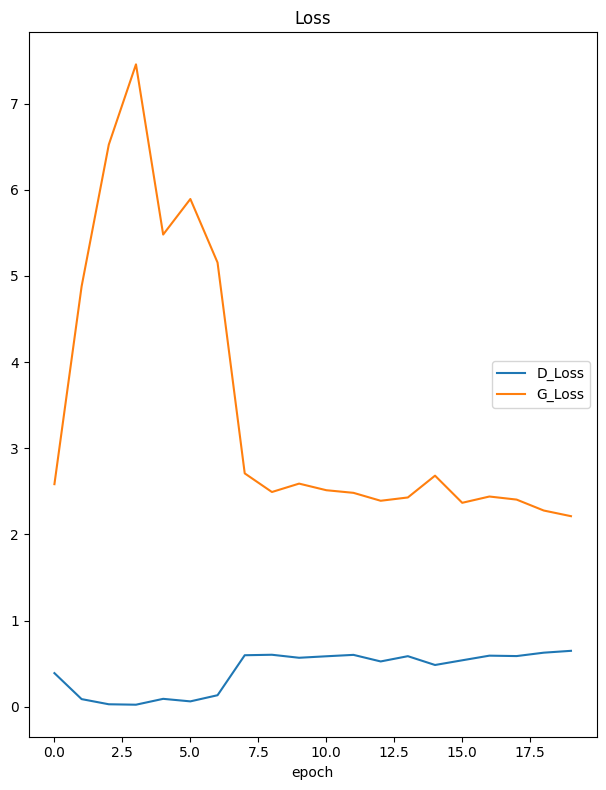

Loss
	D_Loss           	 (min:    0.024, max:    0.650, cur:    0.650)
	G_Loss           	 (min:    2.212, max:    7.454, cur:    2.212)


In [ ]:
#running the model

model_runner(D, G, D_optimizer, G_optimizer,20, 10, train_loader, "DCGAN_noise_", device)

In [ ]:
mse = calculate_mse(test_loader, G, device)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.20310891956090926


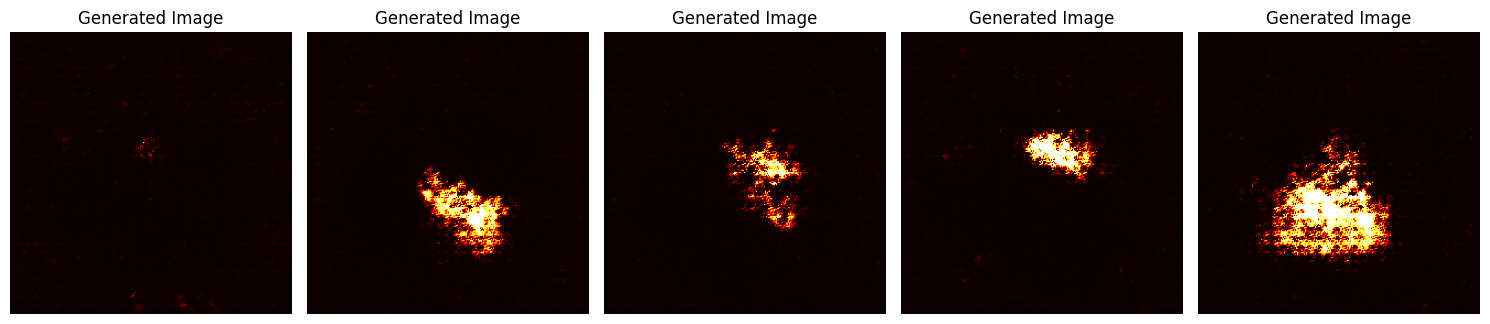

In [ ]:
# Visualize generated images
visualize_generated_images(G, device, num_images_to_generate=5)


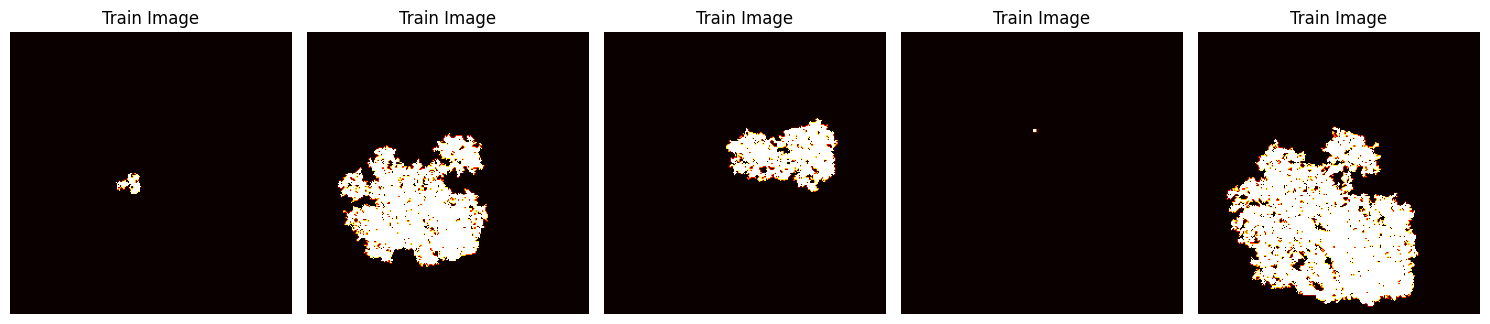

In [ ]:
visualize_random_train_images(train_loader, num_images_to_show=5)

This made my images blurrier and I am starting to get archipelagos. With this in mind, I am going to stick with my model just before.

## Generating More Images in order to Choose One for Comparison with Sensor Data (and for Data Assimilation later)

I will generate 2000 images

In [ ]:
#loading in the best model

G.load_state_dict(torch.load('Models/DCGAN_upsample_100__100.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_74346/4094348678.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


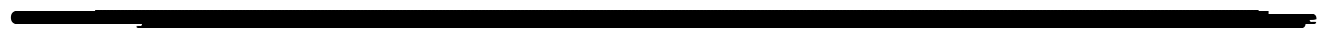

In [ ]:
#this is going to output nonsense, since I am reusing the visualization code, but that's ok
#it will also store the images in a way that I can save them to my device
generated_images = visualize_generated_images(G, device, num_images_to_generate=2000)

In [ ]:
#saving these to a directory
output_dir = 'Images/generated_images_3'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(len(generated_images)):
    plt.figure(figsize=(5, 5))

    plt.imshow(generated_images[i].cpu().permute(1, 2, 0), cmap = "hot")
    plt.title(f'Predicted {i}')
    plt.axis('off')

    plt.savefig(os.path.join(output_dir, f'predicted_{i}.png'))
    plt.close()

## Cleaning Output from the Model

The benefit of using a GAN is that I get really crisp images that closely model the behavior of a fire. The only issue is you, every once in awhile, end up with an archipelago.

This is an image where there is a couple different "islands" of fire. This is obviously bad, because it does not match the actual spread of the wildfire, which starts in one place and then spreads.

Luckily, some quick post processing of my images can remove this.

I will write a helper function that removes these "archipelagos". For an example, let's look at image 81 and 90.

In [ ]:
#saving the generated images as numpy arrays

numpy_images = []
for image in generated_images:
  numpy_images.append(image.cpu().numpy().reshape(256, 256))

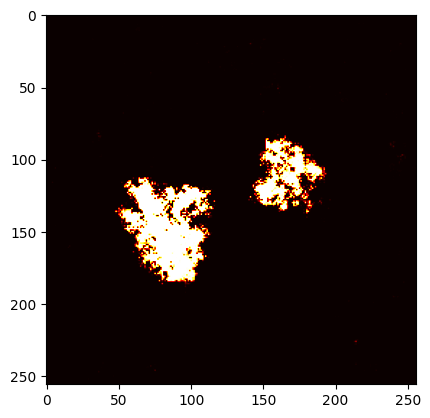

In [ ]:
plt.imshow(numpy_images[90], cmap = 'hot')

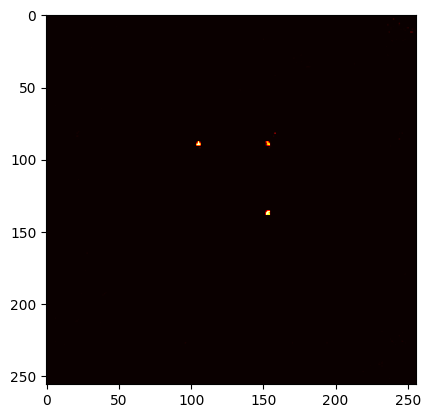

In [ ]:
plt.imshow(numpy_images[81], cmap = 'hot')

As we can see. There are 3 distinct flames in image 81 and 2 distinct flames in image 90. Now, let's test out my new function for choosing and consolidating just the largest flame.

In [ ]:
binary = remove_archipelagos(numpy_images[90])

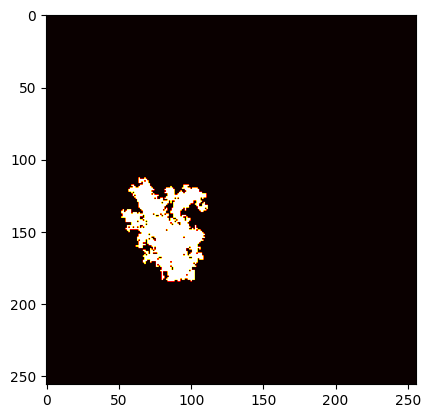

In [ ]:
plt.imshow(binary, cmap = 'hot')

In [ ]:
binary_2 = remove_archipelagos(numpy_images[81])

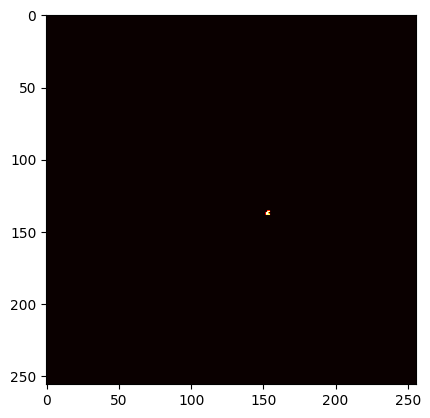

In [ ]:
plt.imshow(binary_2, cmap = 'hot')

Great! We can see that this worked effectively. Now, if I use my GAN to generate images and send them through this function, I can be confident that I have very effectively modelled the fire.

In [ ]:
#sending all my images to the remove archipelagos function

cleaned_images = []

for image in numpy_images:
    cleaned_images.append(remove_archipelagos(image))

## Checking which image is closest to the background image, for Data Assimmilation step

In [ ]:
#loading in the background images

background_images = np.load('Data/Ferguson_fire_background.npy')

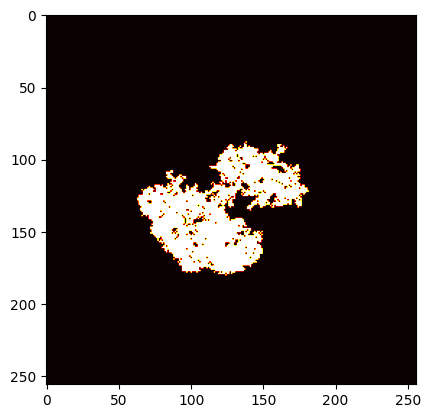

In [ ]:
#I have randomly chosen background image 2 as my comparison image

#let's see what it looks like

plt.imshow(background_images[2], cmap = 'hot')

Now I am going to iterate through my cleaned images and see which is most similar to this background image 2

In [ ]:
mse_for_image_selection(cleaned_images, background_images[2])

[(1322, 0.0374298095703125),
 (1333, 0.0481414794921875),
 (464, 0.04901123046875),
 (1874, 0.051025390625),
 (1765, 0.0516510009765625),
 (867, 0.0547943115234375),
 (1229, 0.0548095703125),
 (1899, 0.0548248291015625),
 (1452, 0.0569915771484375),
 (1314, 0.05743408203125),
 (1956, 0.0574493408203125),
 (961, 0.0577545166015625),
 (868, 0.0578155517578125),
 (263, 0.0579376220703125),
 (462, 0.0580596923828125),
 (73, 0.058929443359375),
 (35, 0.0594482421875),
 (668, 0.059661865234375),
 (1998, 0.0604095458984375),
 (974, 0.06072998046875),
 (931, 0.0608367919921875),
 (855, 0.061004638671875),
 (281, 0.0614013671875),
 (882, 0.0614471435546875),
 (1301, 0.06231689453125),
 (476, 0.0625152587890625),
 (677, 0.06304931640625),
 (1180, 0.063201904296875),
 (1811, 0.063385009765625),
 (1829, 0.0641021728515625),
 (195, 0.0644073486328125),
 (1509, 0.064483642578125),
 (1737, 0.065185546875),
 (740, 0.065277099609375),
 (507, 0.0654144287109375),
 (696, 0.0659637451171875),
 (26, 0.0662

This says that image 1322 is closest to the background image. Let's take a look at it.

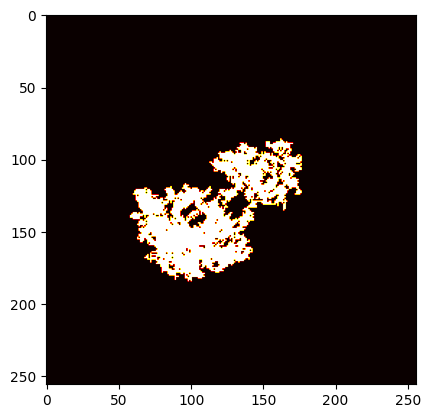

In [ ]:
plt.imshow(cleaned_images[1322], cmap = 'hot')

In [ ]:
#Saving the cleaned images as numpy arrays to my disk

#this will allow me to pass these to the DA team for assimilation

output_dir = 'Images/cleaned_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(len(cleaned_images)):
    np.save(os.path.join(output_dir, f'cleaned_{i}.npy'), cleaned_images[i])

## Comparing to Satellite Data

Per the instructions of Objective 2, Step 3, I will also be comparing my generated images to the Satellite data. First, I will check the MSE for this image that is most similar to the background image, and then I will move to finding the image that is closest to the sensor data.

In [ ]:
#loading in the sensor data

sensor_data = np.load('Data/Ferguson_fire_obs.npy')

In [ ]:
#checking MSE between the sensor data and cleaned image 1322

mse_for_image_selection(sensor_data, cleaned_images[1322])

[(0, 0.0758819580078125),
 (1, 0.0818939208984375),
 (2, 0.0924835205078125),
 (3, 0.0984649658203125),
 (4, 0.108062744140625)]

We can see that the smallest MSE is with sensor image 0 and that **MSE is 0.075**

In [ ]:
#Now I am going to calculate the MSE between the sensor data and all the cleaned images

mse_for_image_selection(cleaned_images, sensor_data[0])

[(1949, 0.042205810546875),
 (1381, 0.042938232421875),
 (1859, 0.0431671142578125),
 (1635, 0.0432891845703125),
 (1235, 0.0436859130859375),
 (1724, 0.0438079833984375),
 (619, 0.043853759765625),
 (506, 0.043975830078125),
 (387, 0.0440521240234375),
 (1184, 0.04412841796875),
 (1499, 0.0442352294921875),
 (1526, 0.04437255859375),
 (131, 0.0445098876953125),
 (1737, 0.044525146484375),
 (1459, 0.044830322265625),
 (1552, 0.04486083984375),
 (241, 0.044921875),
 (1965, 0.0449371337890625),
 (1755, 0.0450286865234375),
 (1620, 0.045166015625),
 (1587, 0.0452117919921875),
 (1450, 0.0453948974609375),
 (350, 0.04541015625),
 (1267, 0.04547119140625),
 (1383, 0.0455169677734375),
 (1887, 0.0455780029296875),
 (255, 0.0458526611328125),
 (103, 0.0459747314453125),
 (1722, 0.0461578369140625),
 (604, 0.0462799072265625),
 (726, 0.046356201171875),
 (270, 0.046417236328125),
 (1759, 0.04644775390625),
 (96, 0.0464630126953125),
 (198, 0.0464935302734375),
 (1920, 0.0465240478515625),
 (19

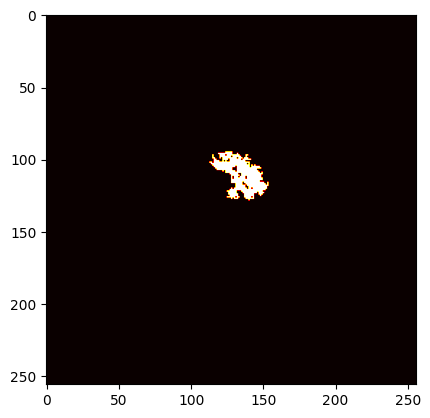

In [ ]:
plt.imshow(cleaned_images[1949], cmap = 'hot')

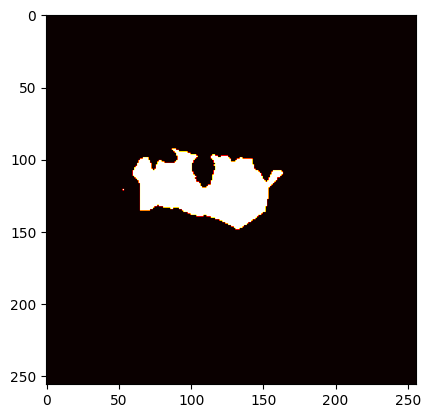

In [ ]:
plt.imshow(sensor_data[0], cmap = 'hot')

The best image (in terms of being closest to sensor_data) is image 1949, and this has an **MSE of 0.042**